starting...
('time needed until eigen decomposition: ', 9.0, ' s')
('iteration: ', 1)
('cluster members number-', 1, ': ', (151L, 1L))
('cluster members number-', 2, ': ', (249L, 1L))


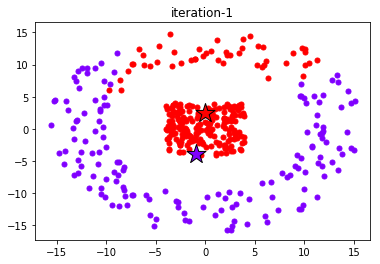

('iteration: ', 2)
('cluster members number-', 1, ': ', (200L, 1L))
('cluster members number-', 2, ': ', (200L, 1L))


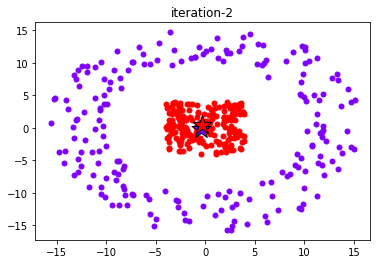

('iteration: ', 3)
('cluster members number-', 1, ': ', (200L, 1L))
('cluster members number-', 2, ': ', (200L, 1L))


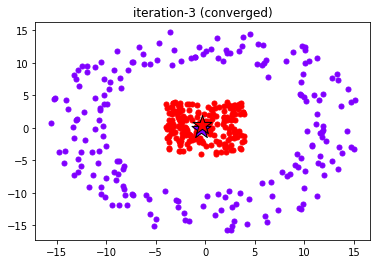

converged!


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import time
from scipy import linalg as LA

filePath1 = "test1_data.txt"
filePath2 = "test2_data.txt"
dataTesting1 = np.loadtxt(filePath1, delimiter=" ")
dataTesting2 = np.loadtxt(filePath2, delimiter=" ")

#define params
k = 2 #numb of clusters
iterationCounter = 0 #clustering iteration counter
input = dataTesting2
var = 1.5 #var in RFB kernel
initCentroidMethod = "badInit" #options: random, kmeans++, badInit, zeroInit

print("starting...")
oldTime = np.around(time.time(), decimals=0)
def initCentroid(dataIn, method, k):
    if (method=="random"):
        result = dataIn[np.random.choice(dataIn.shape[0], k, replace=False)]
    if (method=="kmeans++"):
        euclideanMatrixAllCentroid = np.ndarray(shape=(dataIn.shape[0], 0))
        allCentroid = np.ndarray(shape=(0,dataIn.shape[1]))
        first = dataIn[np.random.choice(dataIn.shape[0], 1, replace=False)]
        allCentroid = np.concatenate((allCentroid, first), axis=0)
        repeatedCent = np.repeat(first, dataIn.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        indexNextCent = (np.argmax(np.matrix(euclideanMatrix)))
        if(k>1):
            for a in range(1,k):
                nextCent = np.matrix(dataIn[np.asscalar(indexNextCent),:])
                allCentroid = np.concatenate((allCentroid, nextCent), axis=0)
                for i in range(0,allCentroid.shape[0]):
                    repeatedCent = np.repeat(allCentroid[i,:], dataIn.shape[0], axis=0)
                    deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
                    euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
                    euclideanMatrixAllCentroid = \
                        np.concatenate((euclideanMatrixAllCentroid, euclideanMatrix), axis=1)
                euclideanFinal = np.min(np.matrix(euclideanMatrixAllCentroid), axis=1)
                indexNextCent = np.argmax(np.matrix(euclideanFinal))
        result = allCentroid
    if (method=="badInit"):
        allCentroid = np.ndarray(shape=(0,dataIn.shape[1]))
        firstIndex = np.random.randint(0,dataIn.shape[0])
        first = np.matrix(dataIn[firstIndex,:])
        dataIn = np.delete(dataIn, firstIndex, 0)
        allCentroid = np.concatenate((allCentroid, first), axis=0)
        repeatedCent = np.repeat(first, dataIn.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        indexNextCent = (np.argmin(np.matrix(euclideanMatrix)))
        if(k>1):
            for a in range(1,k):
                nextCent = np.matrix(dataIn[np.asscalar(indexNextCent),:])
                dataIn = np.delete(dataIn, np.asscalar(indexNextCent), 0)
                euclideanMatrixAllCentroid = np.ndarray(shape=(dataIn.shape[0], 0))
                allCentroid = np.concatenate((allCentroid, nextCent), axis=0)
                for i in range(0,allCentroid.shape[0]):
                    repeatedCent = np.repeat(allCentroid[i,:], dataIn.shape[0], axis=0)
                    deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
                    euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
                    euclideanMatrixAllCentroid = \
                        np.concatenate((euclideanMatrixAllCentroid, euclideanMatrix), axis=1)
                euclideanFinal = np.min(np.matrix(euclideanMatrixAllCentroid), axis=1)
                indexNextCent = np.argmin(np.matrix(euclideanFinal))
        result = allCentroid
    if (method=="zeroInit"):
        result = np.matrix(np.full((k,dataIn.shape[1]),0))
    return result

def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

def plotClusterResult(listClusterMembers, centroid, iteration, converged):
    n = listClusterMembers.__len__()
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    plt.figure("result")
    plt.clf()
    plt.title("iteration-" + iteration)
    for i in range(n):
        col = next(color)
        memberCluster = np.asmatrix(listClusterMembers[i])
        plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]), marker=".", s=100, c=col)
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i in range(n):
        col = next(color)
        plt.scatter(centroid[i, 0], centroid[i, 1], marker="*", s=400, c=col, edgecolors="black")
    if(converged == 0):
        plt.ion()
        plt.show()
        plt.pause(0.1)
    if (converged == 1):
        plt.show(block=True)

def buildSimmilarityMatrix(dataIn):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            weight = RbfKernel(dataIn[i, :], dataIn[j, :], var)
            result[i,j] = weight
    return result

def buildDegreeMatrix(similarityMatrix):
    diag = np.array(similarityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result

def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result

def transformToSpectral(laplacian):
    global k
    e_vals, e_vecs = LA.eig(np.matrix(laplacian))
    ind = e_vals.real.argsort()[:k]
    result = np.ndarray(shape=(laplacian.shape[0],0))
    for i in range(1, ind.shape[0]):
        cor_e_vec = np.transpose(np.matrix(e_vecs[:,np.asscalar(ind[i])]))
        result = np.concatenate((result, cor_e_vec), axis=1)
    return result

simMat = buildSimmilarityMatrix(input)
degMat = buildDegreeMatrix(simMat)
lapMat = unnormalizedLaplacian(simMat, degMat)
transformedData = transformToSpectral(lapMat)
newTime = np.around(time.time(), decimals=0)
print("time needed until eigen decomposition: ", newTime-oldTime, " s")

def kMeans(dataOri, transformedData, centroidInitTransf):
    nCluster = centroidInitTransf.shape[0]
    #looping until converged
    global iterationCounter, k
    while(True):
        iterationCounter +=1
        euclideanMatrixAllCluster = np.ndarray(shape=(transformedData.shape[0], 0))
        #assign data to cluster whose centroid is the closest one
        for i in range(0, nCluster):
            centroidRepeated = np.repeat(centroidInitTransf[i, :], transformedData.shape[0], axis=0)
            deltaMatrix = abs(np.subtract(transformedData, centroidRepeated))
            euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
            euclideanMatrixAllCluster = \
                np.concatenate((euclideanMatrixAllCluster, euclideanMatrix), axis=1)
        clusterMatrix = np.ravel(np.argmin(np.matrix(euclideanMatrixAllCluster), axis=1))
        listClusterMemberTransf = [[] for i in range(k)]
        listClusterMemberOri = [[] for i in range(k)]
        for i in range(0, transformedData.shape[0]):#assign data to cluster regarding cluster matrix
            listClusterMemberTransf[np.asscalar(clusterMatrix[i])].append(np.array(transformedData[i, :]).ravel())
            listClusterMemberOri[np.asscalar(clusterMatrix[i])].append(np.array(dataOri[i, :]).ravel())
        #calculate new centroid
        newCentroidTransf = np.ndarray(shape=(0, centroidInitTransf.shape[1]))
        newCentroidOri = np.ndarray(shape=(0, dataOri.shape[1]))
        print("iteration: ", iterationCounter) 
        for i in range(0,nCluster):
            memberClusterTransf = np.asmatrix(listClusterMemberTransf[i])
            memberClusterOri = np.asmatrix(listClusterMemberOri[i])
            print("cluster members number-", i+1, ": ", memberClusterTransf.shape)
            centroidClusterTransf = memberClusterTransf.mean(axis=0)
            centroidClusterOri = memberClusterOri.mean(axis=0)
            newCentroidTransf = np.concatenate((newCentroidTransf, centroidClusterTransf), axis=0)
            newCentroidOri = np.concatenate((newCentroidOri, centroidClusterOri), axis=0)
        #break when converged
        if((centroidInitTransf == newCentroidTransf).all()):
            break
        # update new centroid
        centroidInitTransf = newCentroidTransf
        plotClusterResult(listClusterMemberOri, newCentroidOri, str(iterationCounter), 0)
        time.sleep(2)
    return listClusterMemberOri, newCentroidOri

centroidInit = initCentroid(transformedData, initCentroidMethod, k)
clusterMemberResult, centroid = kMeans(input, transformedData, centroidInit)
plotClusterResult(clusterMemberResult, centroid, str(iterationCounter) + " (converged)", 1)
print("converged!")